# Section 0.a: Setup

In [261]:
# Package imports
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import sqlite3

In [262]:
# Constants
DB_PATH = '../data/2024.sqlite3'

ALL_CLUBS_DESC = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P', '50°', '56°', '62°']
ALL_CLUBS_ASC = ['62°', '56°', '50°', 'P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']
CLUBS_DESC = ['D', '3W', '3H', '4H', '5', '6', '7', '8', '9', 'P']
CLUBS_ASC = ['P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']
WEDGES_DESC = ['50°', '56°', '62°']
WEDGES_ASC = ['62°', '56°', '50°']

SCATTER_COLORS = [
    "#FF5733",  # Vibrant Orange  
    "#33A1FD",  # Bright Blue  
    "#28A745",  # Fresh Green  
    "#FFC300",  # Bold Yellow  
    "#C70039",  # Deep Red  
    "#900C3F",  # Dark Magenta  
    "#581845",  # Rich Purple  
    "#2ECC71",  # Lively Lime  
    "#F39C12",  # Bright Gold  
    "#1ABC9C",  # Tropical Teal  
]

In [263]:
# Load all data.
connection = sqlite3.connect(DB_PATH)
courses_df = pd.read_sql('SELECT * FROM course_course', connection)
holes_df = pd.read_sql('SELECT * FROM course_hole', connection)
tees_df = pd.read_sql('SELECT * FROM course_tee', connection)

rounds_df = pd.read_sql('SELECT * FROM round_round', connection)
holestats_df = pd.read_sql('SELECT * FROM round_holestats', connection)
strokes_df = pd.read_sql('SELECT * FROM round_stroke', connection)
putts_df = pd.read_sql('SELECT * FROM round_putt', connection)
connection.close()

In [264]:
# Define local helper functions
import math

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180.0)

def meters_to_yards(meters):
    return meters * 1.09361

def get_distance_between_points_meters(lat1, long1, lat2, long2):
    earth_radius_km = 6371
    deg_lat = degrees_to_radians(lat2 - lat1)
    deg_long = degrees_to_radians(long2 - long1)
    a = math.sin(deg_lat / 2) * math.sin(deg_lat / 2) + math.cos(degrees_to_radians(lat1)) * math.cos(degrees_to_radians(lat2)) * math.sin(deg_long / 2) * math.sin(deg_long / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist_km = earth_radius_km * c
    dist_m = dist_km * 1000
    return dist_m

def get_distance_between_points_yards(lat1, long1, lat2, long2):
    dist_m = get_distance_between_points_meters(lat1, long1, lat2, long2)
    dist_yards = meters_to_yards(dist_m)
    return dist_yards

In [265]:
# More helper functions
def parse_coordinates(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str)

def parse_coordinates_with_parentheses(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str[1:-1])

def distance_from_coords(row):
    if row['start_coordinate'] is None or row['end_coordinate'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['end_coordinate'][0], row['end_coordinate'][1]
    )

In [266]:
# Build additional ROUND columns
def get_round_full_shots(row):
    return len(strokes_df[strokes_df['rnd_id'] == row['id']])

def get_round_putts(row):
    return len(putts_df[putts_df['rnd_id'] == row['id']])

def find_gir_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id']) & (holestats_df['gir'] == True)])

def find_gld_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id']) & (holestats_df['gld'] == True)])

def find_scr_for_round(row):
    return len(holestats_df[(holestats_df['rnd_id'] == row['id']) & (holestats_df['scrambling'] == 1)])

rounds_df['num_full_shots'] = rounds_df.apply(get_round_full_shots, axis=1)
rounds_df['num_putts'] = rounds_df.apply(get_round_putts, axis=1)
rounds_df['total_score'] = rounds_df['num_full_shots'] + rounds_df['num_putts']
rounds_df['num_gir'] = rounds_df.apply(find_gir_for_round, axis=1)
rounds_df['num_gld'] = rounds_df.apply(find_gld_for_round, axis=1)
rounds_df['num_scr'] = rounds_df.apply(find_scr_for_round, axis=1)

In [267]:
# Build additional STROKE columns
def fill_penalty_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if not strokes_df.loc[(strokes_df['rnd_id'] == row_rnd_id) &\
        (strokes_df['hole_id'] == row_hole_id) &\
        (strokes_df['stroke_number'] == row_stroke_num + 1) &\
        (strokes_df['penalty'])].empty:
        return True
    return False
    
def fill_green_hit_result(row):
    row_rnd_id = row['rnd_id']
    row_hole_id = row['hole_id']
    row_stroke_num = row['stroke_number']
    if strokes_df.loc[(strokes_df['rnd_id'] == row_rnd_id) &\
        (strokes_df['hole_id'] == row_hole_id) &\
        (strokes_df['stroke_number'] == row_stroke_num + 1)].empty:
        return True
    return False

def fill_next_putt(row):
    if row['hit_green']:
        putt_distances_for_hole = putts_df[(putts_df['rnd_id'] == row['rnd_id']) & \
            (putts_df['hole_id'] == row['hole_id']) & \
            (putts_df['stroke_number'] == row['stroke_number'] + 1)]['distance']
        if not putt_distances_for_hole.empty:
            return putt_distances_for_hole.iloc[0]
        else:
            return np.nan
    else:
        return np.nan

strokes_df['start_coordinate'] = strokes_df['start_coordinate'].astype(str).apply(parse_coordinates)
strokes_df['end_coordinate'] = strokes_df['end_coordinate'].astype(str).apply(parse_coordinates)
strokes_df['distance'] = strokes_df.apply(distance_from_coords, axis=1)
strokes_df['penalty_result'] = strokes_df.apply(fill_penalty_result, axis=1)
strokes_df['hit_green'] = strokes_df.apply(fill_green_hit_result, axis=1)
strokes_df['hit_green_putt_dist'] = strokes_df.apply(fill_next_putt, axis=1)

In [268]:
# Cleanup - only use data from valid rounds
rounds_df = rounds_df[rounds_df['total_score'] > 80]
strokes_df = strokes_df[strokes_df['rnd_id'].isin(rounds_df['id'])]
putts_df = putts_df[putts_df['rnd_id'].isin(rounds_df['id'])]

rounds_df = rounds_df.merge(courses_df, how='inner', left_on='course_id', right_on='id')

In [269]:
# Data overview
rounds_2024_df = rounds_df.loc[(rounds_df['date_played'] >= '2024-01-01') & (rounds_df['date_played'] <= '2024-12-31')]

print(f'''Data Overview
// Course Data
/ Courses: {len(courses_df)}
/ Tees: {len(tees_df)}
/ Holes: {len(holes_df)}
// Round Data
/ Rounds Recorded (Total): {len(rounds_df)}
/ Rounds Recorded (2024): {len(rounds_2024_df)}
/ Number of Strokes Recorded: {len(strokes_df)}
/ Number of Putts Recorded: {len(putts_df)}
/ % of Strokes Recorded Were Putts: {(len(putts_df) / (len(putts_df) + len(strokes_df)) * 100):.2f}%
/ Average Score Per Round: {((len(putts_df) + len(strokes_df)) / len(rounds_df)):.2f}
''')

Data Overview
// Course Data
/ Courses: 14
/ Tees: 36
/ Holes: 234
// Round Data
/ Rounds Recorded (Total): 21
/ Rounds Recorded (2024): 21
/ Number of Strokes Recorded: 1198
/ Number of Putts Recorded: 726
/ % of Strokes Recorded Were Putts: 37.73%
/ Average Score Per Round: 91.62



# Section 1: Scoring Statistics

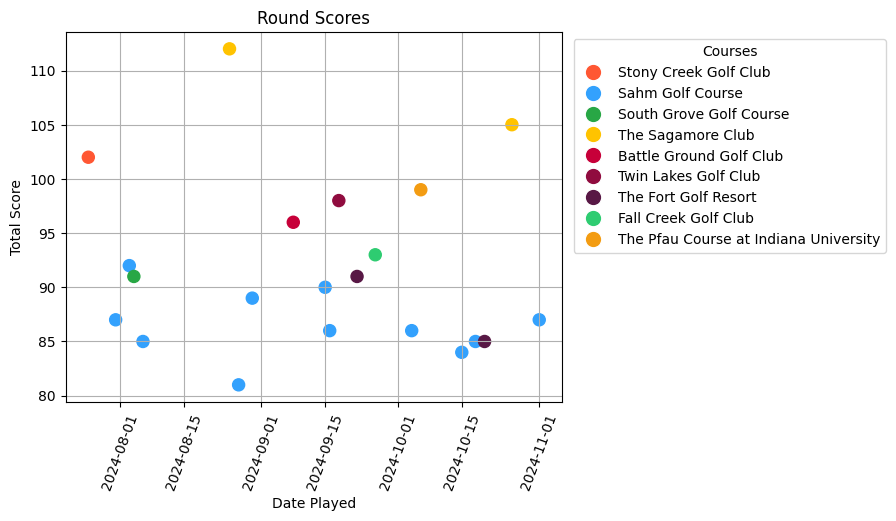

In [270]:
# Assume rounds['course_id'] exists in your DataFrame
course_ids = rounds_df['name'].unique()

# Create a dictionary to map course_ids to colors
course_color_map = {course_id: SCATTER_COLORS[i % len(SCATTER_COLORS)] for i, course_id in enumerate(course_ids)}

# Map colors to rounds based on course_id
rounds_df['color'] = rounds_df['name'].map(course_color_map)

# Prepare data for scatter plot
dates = [pd.to_datetime(d) for d in rounds_df['date_played']]
scatter_colors = rounds_df['color']  # Colors mapped to course_id

# Create the scatter plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=course_id)
    for course_id, color in course_color_map.items()
]
ax.legend(handles=legend_elements, title="Courses", bbox_to_anchor=(1.01, 1))

ax.scatter(dates, rounds_df['total_score'], s=75, color=scatter_colors)
ax.tick_params(axis='x', labelrotation=70)
ax.grid(True)
ax.set_title('Round Scores')
ax.set_xlabel('Date Played')
ax.set_ylabel('Total Score')
plt.show()

,id_x,date_played,course_id_x,played_tee_id,finish_time,group_makeup,holes_completed,mobility,notes,round_counts_toward_hci,...,image_url,num_holes,color_x,id,color_y,name_y,yardage,rating,course_id_y,slope
1,16.0,2024-07-31,1.0,2.0,9:20pm,Randoms,18.0,Walking,None,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
2,18.0,2024-08-03,1.0,2.0,None,Mixed,18.0,Walking,Good round w/ Jacob. That 9 on 10 really threw...,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
3,26.0,2024-08-06,1.0,2.0,None,Mixed,18.0,Walking,None,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
4,31.0,2024-08-27,1.0,2.0,8:30,Friends,18.0,Carting,All time best 81! Played with Joel Van Auken f...,0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0
5,32.0,2024-08-30,1.0,2.0,5:00pm,Randoms,18.0,Pushing,"Slow round, felt like I was just barely hangin...",0.0,...,https://sahmgolf.com/wp-content/uploads/2019/0...,18.0,#33A1FD,2,ffffff,Men's,6061,68.4,1,110.0


Slope/Score Correlation: [[1.         0.65520759]
 [0.65520759 1.        ]]
Rating/Score Correlation: [[1.         0.32030555]
 [0.32030555 1.        ]]


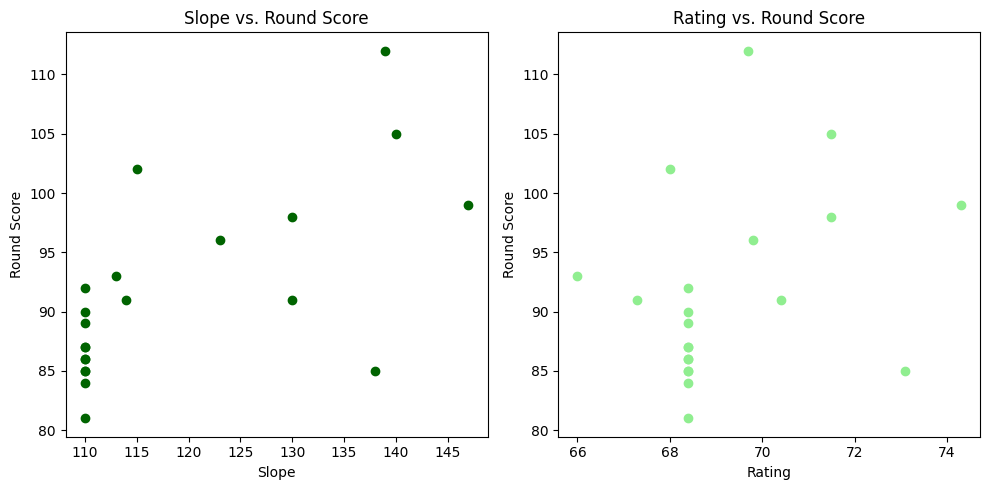

In [271]:
rounds_tees_df = rounds_df.merge(tees_df, how='right', left_on='played_tee_id', right_on='id')
rounds_tees_df = rounds_tees_df[(~rounds_tees_df['id'].isna()) & (~rounds_tees_df['id_x'].isna())]
fix, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].scatter(rounds_tees_df['slope'], rounds_tees_df['total_score'], color='darkgreen')
axs[0].set_xlabel('Slope')
axs[0].set_ylabel('Round Score')
axs[0].set_title('Slope vs. Round Score')

axs[1].scatter(rounds_tees_df['rating'], rounds_tees_df['total_score'], color='lightgreen')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Round Score')
axs[1].set_title('Rating vs. Round Score')

display(rounds_tees_df.head())
r_slope = np.corrcoef(rounds_tees_df['slope'], rounds_tees_df['total_score'])
r_rating = np.corrcoef(rounds_tees_df['rating'], rounds_tees_df['total_score'])

print(f'Slope/Score Correlation: {r_slope}')
print(f'Rating/Score Correlation: {r_rating}')

In [272]:
# Round Stats Overview
average_gir_per_round = rounds_df['num_gir'].mean()
average_gld_per_round = rounds_df['num_gld'].mean()
average_scr_per_round = rounds_df['num_scr'].mean()
print(f'Average GIR per round: {average_gir_per_round:.2f}')
print(f'Average GLD per round: {average_gld_per_round:.2f}')
print(f'Average SCR per round: {average_scr_per_round:.2f}')
print(f'Average # Putts per round: {rounds_df['num_putts'].mean():.2f}')

Average GIR per round: 4.48
Average GLD per round: 7.24
Average SCR per round: 1.48
Average # Putts per round: 34.57


In [273]:
# Stats By Course
rounds_by_course = rounds_df.merge(courses_df, how='inner', left_on='course_id', right_on='id')
mean_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].mean() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'Ave. Score', 
        'num_putts': 'Ave. Putts', 
        'num_gld': 'Ave. GLD', 
        'num_gir': 'Ave. GIR', 
        'num_scr': 'Ave. Up & Down'
    })

median_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].median() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'Med. Score', 
        'num_putts': 'Med. Putts', 
        'num_gld': 'Med. GLD', 
        'num_gir': 'Med. GIR', 
        'num_scr': 'Med. Up & Down'
    })

std_rounds_by_course = rounds_by_course.groupby('name_y')[['total_score', 'num_putts', 'num_gld', 'num_gir', 'num_scr']].std() \
    .dropna() \
    .reset_index() \
    .rename(columns={
        'name_y': 'Course', 
        'total_score': 'SD Score', 
        'num_putts': 'SD Putting', 
        'num_gld': 'SD GLD', 
        'num_gir': 'SD GIR', 
        'num_scr': 'SD Up & Down'
    })

display(mean_rounds_by_course)
display(median_rounds_by_course)
display(std_rounds_by_course)

,Course,Ave. Score,Ave. Putts,Ave. GLD,Ave. GIR,Ave. Up & Down
0,Battle Ground Golf Club,96.000000,38.000000,9.000000,3.000000,1.000000
1,Fall Creek Golf Club,93.000000,31.000000,7.000000,2.000000,2.000000
2,Sahm Golf Course,86.545455,34.636364,8.090909,5.454545,1.818182
3,South Grove Golf Course,91.000000,31.000000,4.000000,3.000000,2.000000
4,Stony Creek Golf Club,102.000000,37.000000,3.000000,4.000000,0.000000
5,The Fort Golf Resort,88.000000,33.500000,6.000000,5.500000,1.500000
6,The Pfau Course at Indiana University,99.000000,40.000000,7.000000,6.000000,0.000000
7,The Sagamore Club,108.500000,33.000000,8.500000,0.500000,1.500000
8,Twin Lakes Golf Club,98.000000,35.000000,4.000000,4.000000,0.000000


,Course,Med. Score,Med. Putts,Med. GLD,Med. GIR,Med. Up & Down
0,Battle Ground Golf Club,96.0,38.0,9.0,3.0,1.0
1,Fall Creek Golf Club,93.0,31.0,7.0,2.0,2.0
2,Sahm Golf Course,86.0,34.0,8.0,5.0,2.0
3,South Grove Golf Course,91.0,31.0,4.0,3.0,2.0
4,Stony Creek Golf Club,102.0,37.0,3.0,4.0,0.0
5,The Fort Golf Resort,88.0,33.5,6.0,5.5,1.5
6,The Pfau Course at Indiana University,99.0,40.0,7.0,6.0,0.0
7,The Sagamore Club,108.5,33.0,8.5,0.5,1.5
8,Twin Lakes Golf Club,98.0,35.0,4.0,4.0,0.0


,Course,SD Score,SD Putting,SD GLD,SD GIR,SD Up & Down
0,Sahm Golf Course,3.012097,2.335497,1.868397,2.067058,0.981650
1,The Fort Golf Resort,4.242641,0.707107,1.414214,0.707107,0.707107
2,The Sagamore Club,4.949747,0.000000,2.121320,0.707107,2.121320


In [274]:
# Group hole stats by par and total round score
def get_score_for_hole(row):
    return len(strokes_df[
                (strokes_df['rnd_id'] == row['rnd_id']) & \
                (strokes_df['hole_id'] == row['hole_id']) \
           ]) + \
           len(putts_df[
                (putts_df['rnd_id'] == row['rnd_id']) & \
                (putts_df['hole_id'] == row['hole_id']) \
           ])

holestats_scoring = holestats_df.merge(holes_df, how='inner', left_on='hole_id', right_on='id')
holestats_scoring = holestats_scoring[holestats_scoring['rnd_id'].isin(rounds_df['id_x'])]
holestats_scoring['total_for_played_hole'] = holestats_scoring.apply(get_score_for_hole, axis=1)

scoring_by_par = holestats_scoring.groupby('par')['total_for_played_hole'] 
mean_scores_by_par = scoring_by_par.mean().reset_index()
median_scores_by_par = scoring_by_par.median()
std_scores_by_par = scoring_by_par.std()

overall_scoring_by_par = mean_scores_by_par \
    .merge(median_scores_by_par, on='par') \
    .merge(std_scores_by_par, on='par') \
    .rename(columns={
        'par': 'Par',
        'total_for_played_hole_x': 'Mean Score',
        'total_for_played_hole_y': 'Median Score',
        'total_for_played_hole': 'Std. Dev.',
    })
overall_scoring_by_par.head()

,Par,Mean Score,Median Score,Std. Dev.
0,3,3.819277,4.0,0.885446
1,4,5.227848,5.0,1.107938
2,5,6.344828,6.0,1.516595


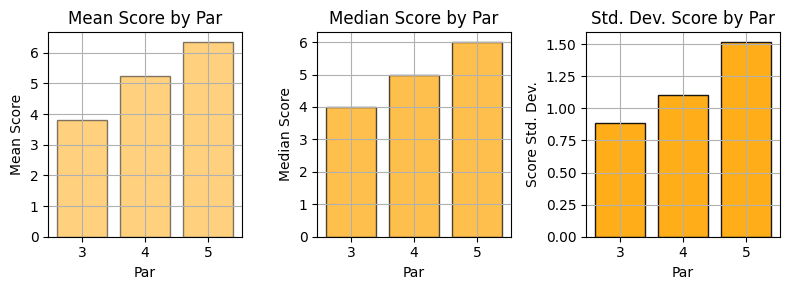

In [275]:
# Visualize Overall Scoring
fig, axs = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)
axs[0].bar(overall_scoring_by_par['Par'], overall_scoring_by_par['Mean Score'], color='orange', alpha=0.5, edgecolor='black')
axs[0].set_title('Mean Score by Par')
axs[0].set_xlabel('Par')
axs[0].set_ylabel('Mean Score')
axs[0].grid(True)

axs[1].bar(overall_scoring_by_par['Par'], overall_scoring_by_par['Median Score'], color='orange', alpha=0.7, edgecolor='black')
axs[1].set_title('Median Score by Par')
axs[1].set_xlabel('Par')
axs[1].set_ylabel('Median Score')
axs[1].grid(True)

axs[2].bar(overall_scoring_by_par['Par'], overall_scoring_by_par['Std. Dev.'], color='orange', alpha=0.9, edgecolor='black')
axs[2].set_title('Std. Dev. Score by Par')
axs[2].set_xlabel('Par')
axs[2].set_ylabel('Score Std. Dev.')
axs[2].grid(True)

# Section 2: Club Statistics

In [276]:
# Clean STROKE data, now that we are complete with ROUND analysis.
# strokes_df = strokes_df.dropna()
strokes_df = strokes_df[strokes_df['club'] != 'Club']

In [277]:
# Build Description DF
mean_distances_by_club = strokes_df.groupby('club')[['distance']].mean().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Mean Distance'})

median_distances_by_club = strokes_df.groupby('club')[['distance']].median().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Median Distance'})

std_distances_by_club = strokes_df.groupby('club')[['distance']].std().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Std. Dev.'})

min_distances_by_club = strokes_df.groupby('club')[['distance']].min().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Min'})

max_distances_by_club = strokes_df.groupby('club')[['distance']].max().reindex(ALL_CLUBS_ASC).reset_index() \
    .rename(columns={'club': 'Club', 'distance': 'Max'})

distances_by_club = mean_distances_by_club.merge(median_distances_by_club, on='Club') \
    .merge(std_distances_by_club, on='Club') \
    .merge(min_distances_by_club, on='Club') \
    .merge(max_distances_by_club, on='Club')

# Display the result
display(distances_by_club)

,Club,Mean Distance,Median Distance,Std. Dev.,Min,Max
0,62°,28.539593,27.386890,18.660297,0.000000,79.014872
1,56°,33.361426,23.483797,26.771492,0.000000,129.490469
2,50°,77.102717,88.150380,32.854008,0.000000,141.619374
3,P,88.720764,111.968615,47.488390,13.035304,149.739737
4,9,120.593210,127.301134,35.775498,26.404489,190.887843
5,8,133.479652,140.926472,31.387644,16.335350,190.243333
6,7,127.882384,141.789677,44.097137,10.805023,208.805957
7,6,144.453370,156.956075,45.017311,34.624112,243.894000
8,5,139.604796,159.350501,56.094693,19.428896,220.560562
9,4H,162.595734,177.312044,58.762058,29.169833,253.436610


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

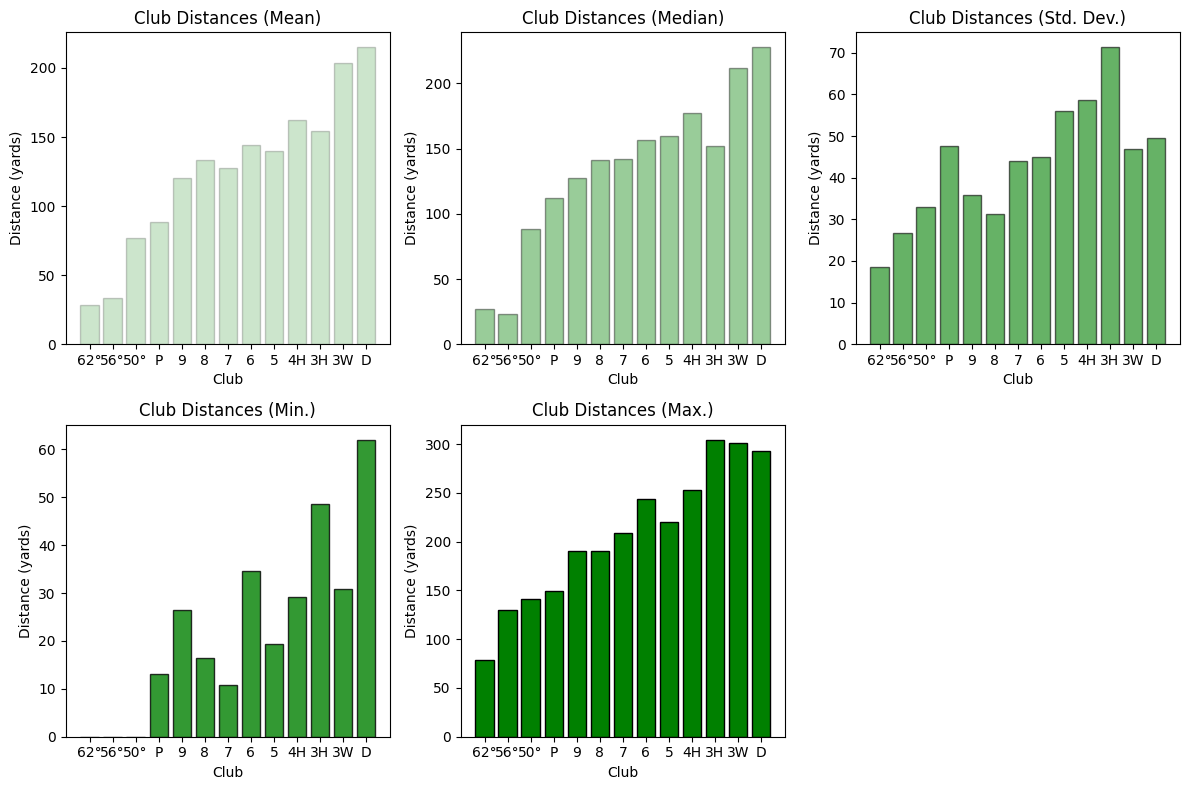

In [278]:
# Visualize Club Descriptions
fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axs[0][0].bar(ALL_CLUBS_ASC, distances_by_club['Mean Distance'], color='green', alpha=0.2, edgecolor='black')
axs[0][0].set_title('Club Distances (Mean)')
axs[0][0].set_xlabel('Club')
axs[0][0].set_ylabel('Distance (yards)')

axs[0][1].bar(ALL_CLUBS_ASC, distances_by_club['Median Distance'], color='green', alpha=0.4, edgecolor='black')
axs[0][1].set_title('Club Distances (Median)')
axs[0][1].set_xlabel('Club')
axs[0][1].set_ylabel('Distance (yards)')

axs[0][2].bar(ALL_CLUBS_ASC, distances_by_club['Std. Dev.'], color='green', alpha=0.6, edgecolor='black')
axs[0][2].set_title('Club Distances (Std. Dev.)')
axs[0][2].set_xlabel('Club')
axs[0][2].set_ylabel('Distance (yards)')

axs[1][0].bar(ALL_CLUBS_ASC, distances_by_club['Min'], color='green', alpha=0.8, edgecolor='black')
axs[1][0].set_title('Club Distances (Min.)')
axs[1][0].set_xlabel('Club')
axs[1][0].set_ylabel('Distance (yards)')

axs[1][1].bar(ALL_CLUBS_ASC, distances_by_club['Max'], color='green', alpha=1, edgecolor='black')
axs[1][1].set_title('Club Distances (Max.)')
axs[1][1].set_xlabel('Club')
axs[1][1].set_ylabel('Distance (yards)')

axs[1][2].axis('off')

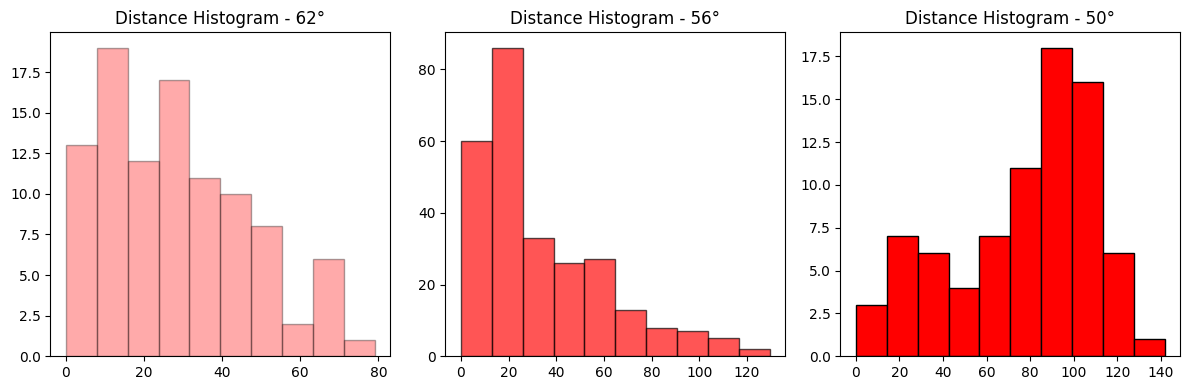

In [279]:
# Plot wedge histograms
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
next_alpha = 0
for i, wedge in enumerate(WEDGES_ASC):
    strokes_for_wedge = strokes_df.where(strokes_df['club'] == wedge)
    axs[i].hist(x = strokes_for_wedge[['distance']], edgecolor='black', color='red', bins=10, alpha = (next_alpha := next_alpha + 0.3333))
    axs[i].set_title(f'Distance Histogram - {wedge}')

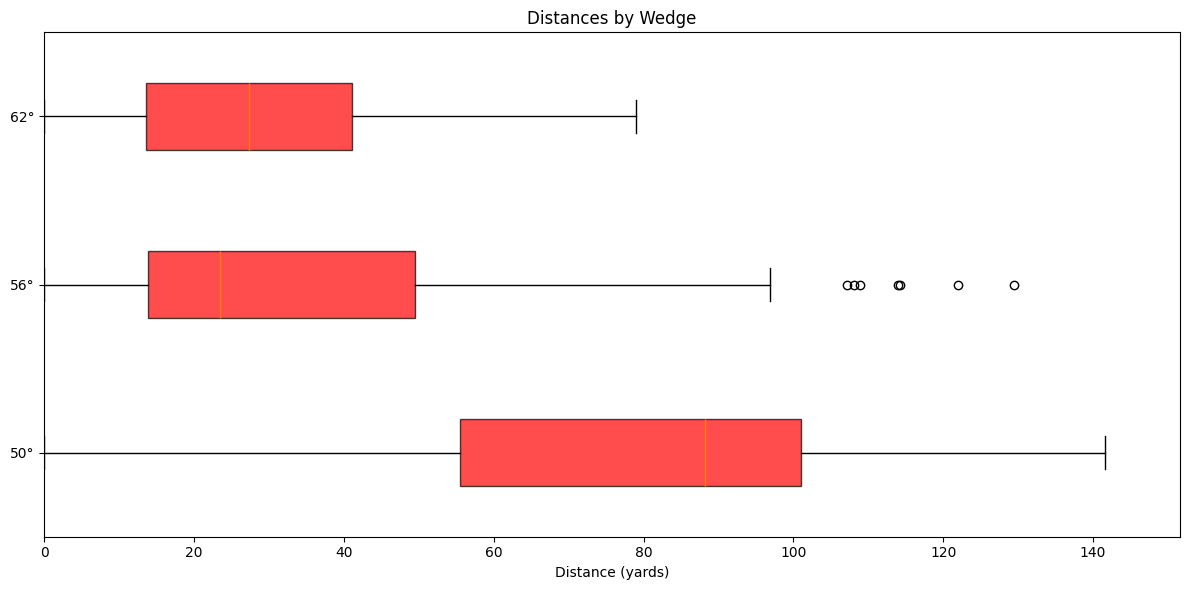

In [280]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, wedge in enumerate(WEDGES_DESC):
    strokes_for_wedge = strokes_df[strokes_df['club'] == wedge]  # Filter strokes by club
    plt.boxplot(strokes_for_wedge['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='red', alpha=0.7, color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                positions=[i], widths=0.4)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Wedge')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(WEDGES_DESC)), WEDGES_DESC)  # Label clubs on the y-axis
plt.xlim(0, strokes_df[strokes_df['club'] == '50°']['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()

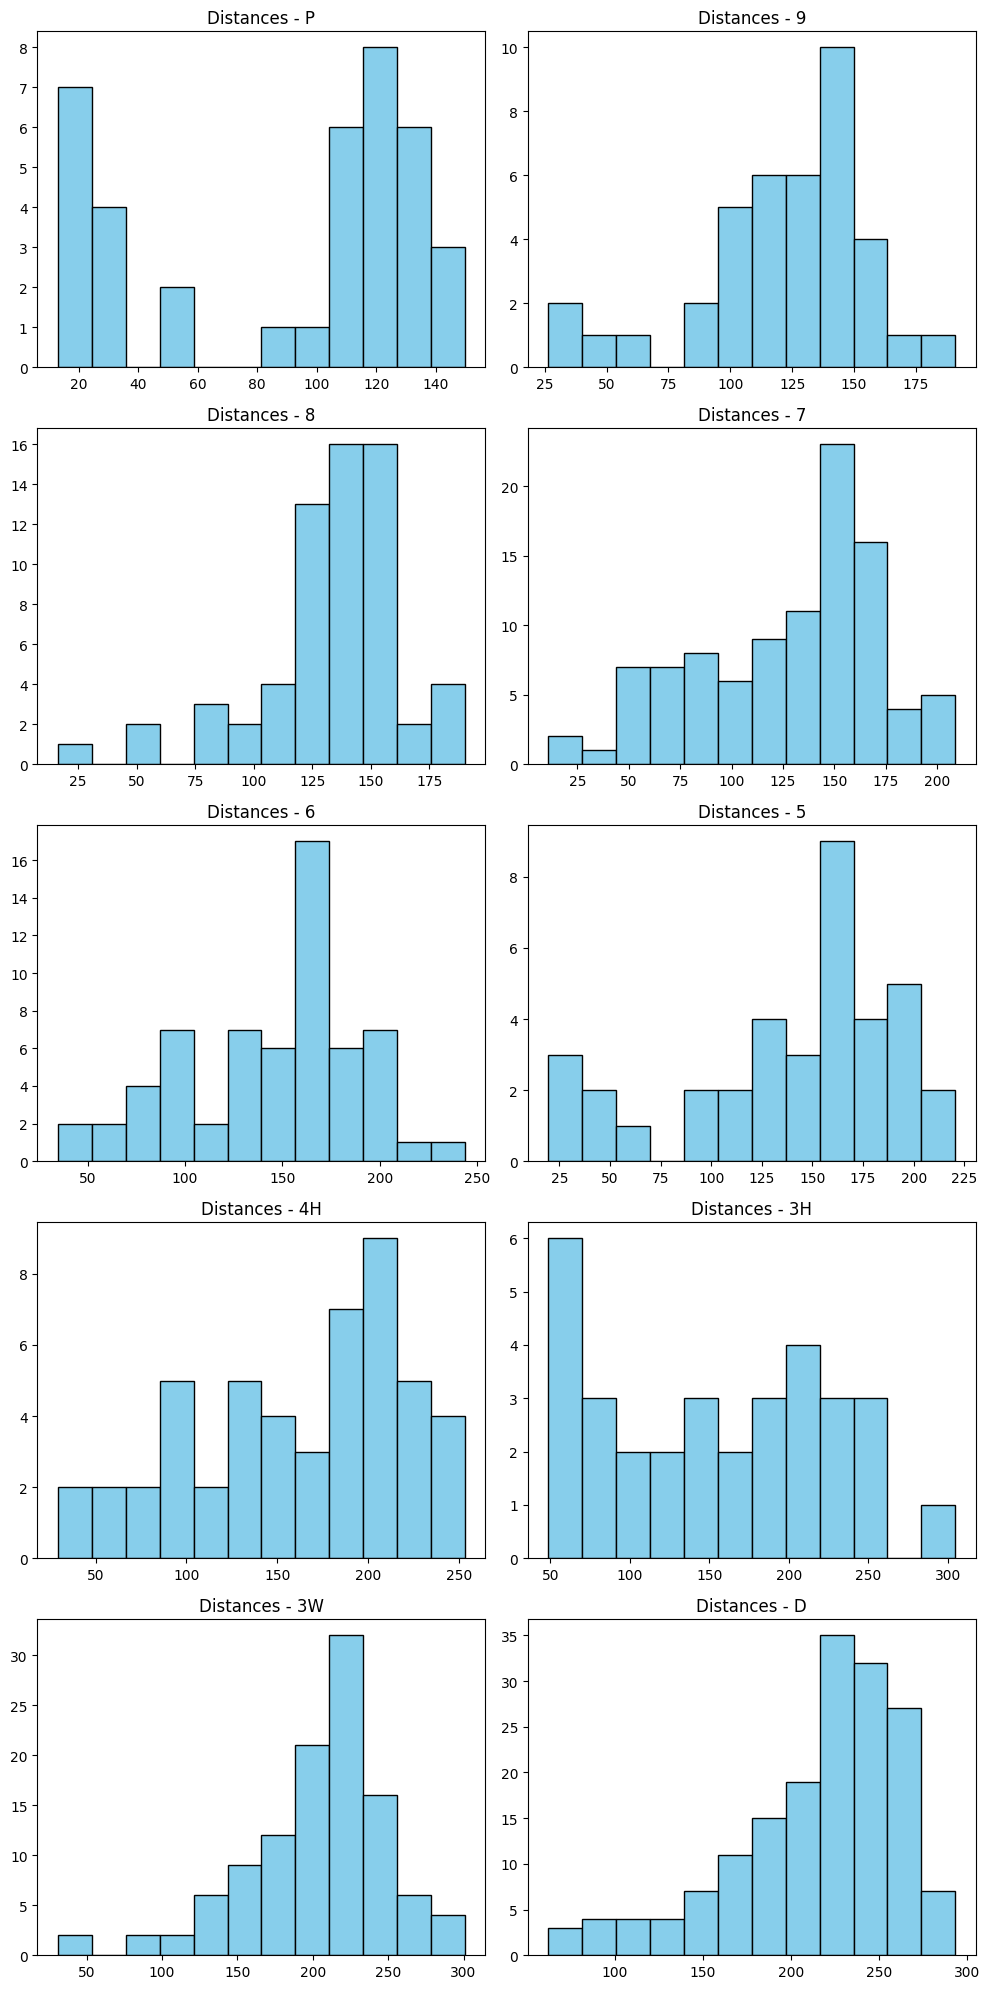

In [281]:
# Plot other club histograms
fig, axs = plt.subplots(5, 2, figsize=(10, 20), tight_layout=True)
for i, club in enumerate(CLUBS_ASC):
    strokes_for_club = strokes_df.where(strokes_df['club'] == club)
    axs[i // 2][i % 2].hist(x = strokes_for_club[['distance']], edgecolor='black', color='skyblue', bins=12)
    axs[i // 2][i % 2].set_title(f'Distances - {club}')

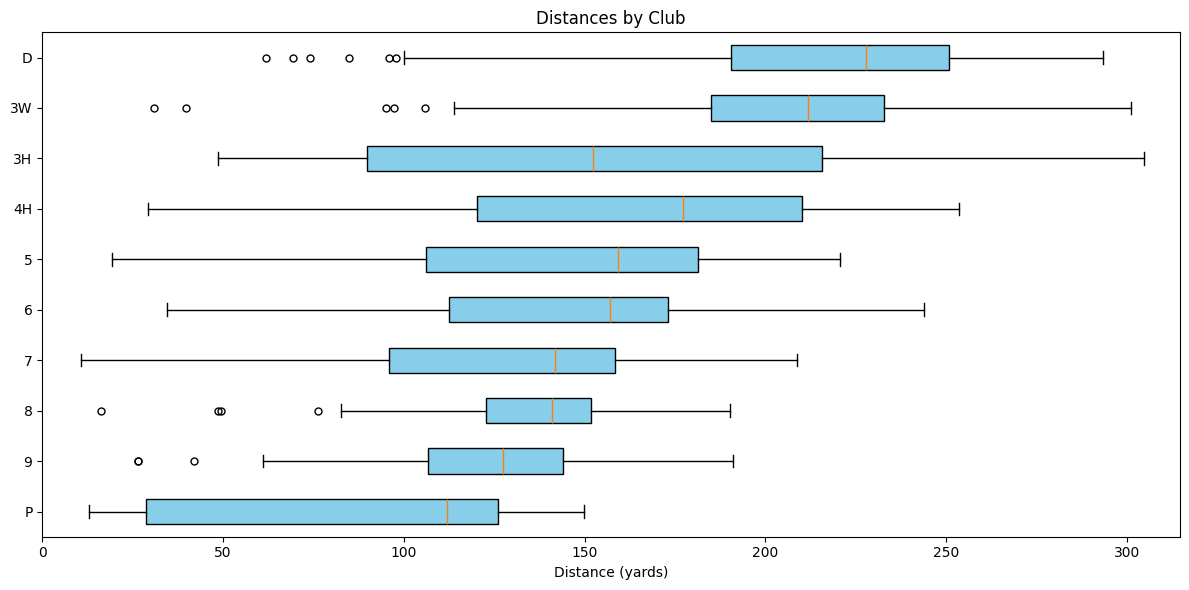

In [282]:
plt.figure(figsize=(12, 6))

# Iterate through each club to plot boxplots next to each other
for i, club in enumerate(CLUBS_ASC):
    strokes_for_club = strokes_df[strokes_df['club'] == club]  # Filter strokes by club
    plt.boxplot(strokes_for_club['distance'], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='black', linewidth=1),  # Thicker boxes' edges
                whiskerprops=dict(color='black', linewidth=1),
                capprops=dict(color='black', linewidth=1),
                flierprops=dict(marker='o', color='red', markersize=5, linewidth=1),
                positions=[i], widths=0.5)  # Adjust width to make boxes thicker

# Customize the plot
plt.title('Distances by Club')
plt.xlabel('Distance (yards)')
plt.yticks(range(len(CLUBS_ASC)), CLUBS_ASC)  # Label clubs on the y-axis
plt.xlim(0, strokes_df['distance'].max() + 10)  # Adjust x-axis to fit data

# Show the plot
plt.tight_layout()
plt.show()

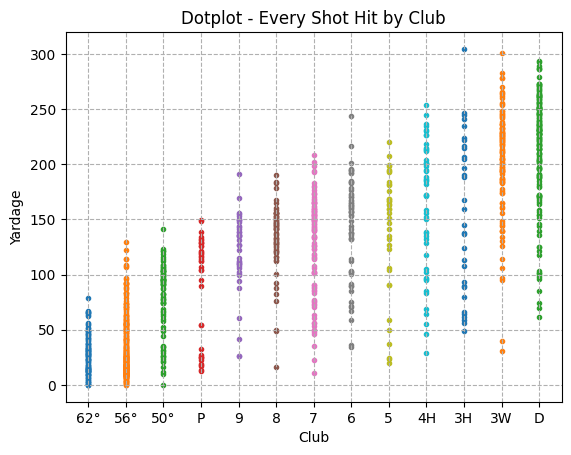

In [283]:
from itertools import cycle
# Dotplot - every single shot hit
fig, ax = plt.subplots()
for i, club in enumerate(ALL_CLUBS_ASC):
    distances_for_club = strokes_df[strokes_df['club'] == club]['distance']
    ax.scatter(x=[club] * len(distances_for_club), y=distances_for_club, marker='.')
ax.set_title('Dotplot - Every Shot Hit by Club')
ax.set_xlabel('Club')
ax.set_ylabel('Yardage')
ax.grid(True, linestyle='--')
plt.show()

Text(0.5, 1.0, 'Probability of Hitting Green with Each Club')

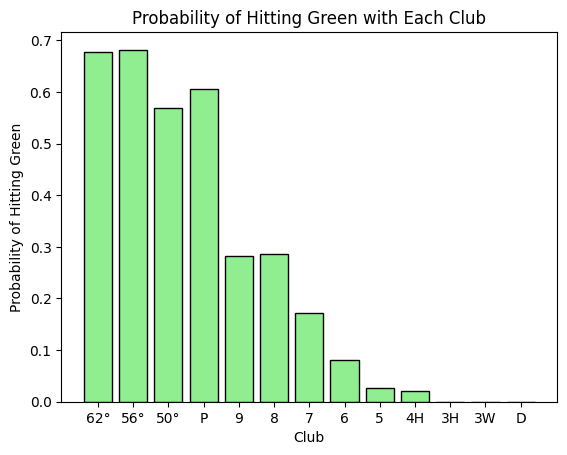

In [284]:
# Likelihood of hitting green with each club
club_strokes_with_hit_green = strokes_df[(strokes_df['hit_green'] == True) & (strokes_df['club'] != 'Club')]
club_strokes_with_hit_green_by_club = club_strokes_with_hit_green.groupby('club')

strokes_by_club = strokes_df[strokes_df['club'] != 'Club'].groupby('club')

hit_green_percentages_by_club = club_strokes_with_hit_green_by_club.size() / strokes_by_club.size()
hit_green_percentages_by_club = hit_green_percentages_by_club.reindex(ALL_CLUBS_ASC)
hit_green_percentages_by_club.fillna(0, inplace=True)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(hit_green_percentages_by_club.index, hit_green_percentages_by_club, color='lightgreen', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green with Each Club')

#### On Probability of Hitting Green with Each Club Metrics

It's important to be careful with analyzing this metric - it might be tempting to think of the goal with every shot to be to hit the green, but this is not always the case. For example: second shots on Par 5's (first approach shot of the hole) usually have the goal of getting within reach for a manageable 3rd shot - going for the green is a rarity. The same logic applies to long par 4's. So while that shot may count as a 'missed' green, the intention may still be correct.

In [285]:
strokes_with_green_yardages = strokes_df.copy(deep=True)
strokes_with_green_yardages = strokes_with_green_yardages.merge(holes_df, how='inner', left_on='hole_id', right_on='id')
strokes_with_green_yardages['center_green_point'] = strokes_with_green_yardages['center_green_point'].astype('str').apply(parse_coordinates_with_parentheses)

def distance_to_green(row):
    if row['start_coordinate'] is None or row['center_green_point'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['center_green_point'][0], row['center_green_point'][1]
    )
strokes_with_green_yardages['dist_to_green'] = strokes_with_green_yardages.apply(distance_to_green, axis=1)

strokes_with_green_yardages.head()

,id_x,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,distance,penalty_result,hit_green,hit_green_putt_dist,id_y,hole_number,nickname,par,bound_points,center_green_point,course_id,dist_to_green
0,323,D,"[40.03085445325074, -85.95908313989639]","[40.030830257356165, -85.95999374985695]",1,37,15,0,84.839650,False,False,NaN,37,1,None,5,"[[40.030777308750565, -85.95830798149109], [40...","[40.031098722199005, -85.96423834562302]",5,480.928198
1,324,8,"[40.030830257356165, -85.95999374985695]","[40.030948027743634, -85.96097409725189]",2,37,15,0,92.398552,False,False,NaN,37,1,None,5,"[[40.030777308750565, -85.95830798149109], [40...","[40.031098722199005, -85.96423834562302]",5,396.567670
2,325,4H,"[40.030948027743634, -85.96097409725189]","[40.03083301710051, -85.96199333667755]",3,37,15,0,95.928235,False,False,NaN,37,1,None,5,"[[40.030777308750565, -85.95830798149109], [40...","[40.031098722199005, -85.96423834562302]",5,304.491449
3,326,7,"[40.03083301710051, -85.96199333667755]","[40.03105212761166, -85.96410691738129]",4,37,15,0,198.594728,False,True,65.0,37,1,None,5,"[[40.030777308750565, -85.95830798149109], [40...","[40.031098722199005, -85.96423834562302]",5,211.519043
4,327,8,"[40.03051108895679, -85.96388697624207]","[40.03091407651929, -85.96550971269608]",1,38,15,0,158.844518,False,False,NaN,38,2,None,3,"[[40.0312537805415, -85.96514225006104], [40.0...","[40.030777308750565, -85.96547484397888]",5,151.352556


Text(0.5, 0, 'Approximate Range (Yards)')

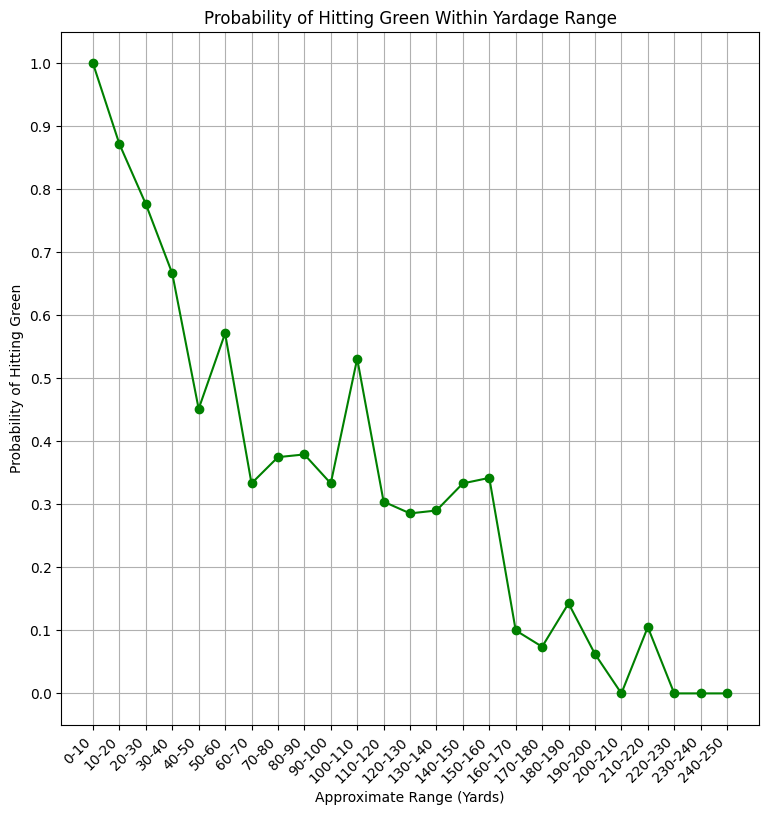

In [286]:
probs = []
labels = []
for y in range(25):
    lower = y * 10
    upper = (y + 1) * 10
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    num_strokes_within_range_hit_green = len(strokes_with_range_hit_green)
    if num_strokes_within_range == 0:
        probs.append(0)
    else:
        probs.append(num_strokes_within_range_hit_green / num_strokes_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(probs, color='green', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green Within Yardage Range')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range (Yards)')

Text(0.5, 0, 'Approximate Range (Yards)')

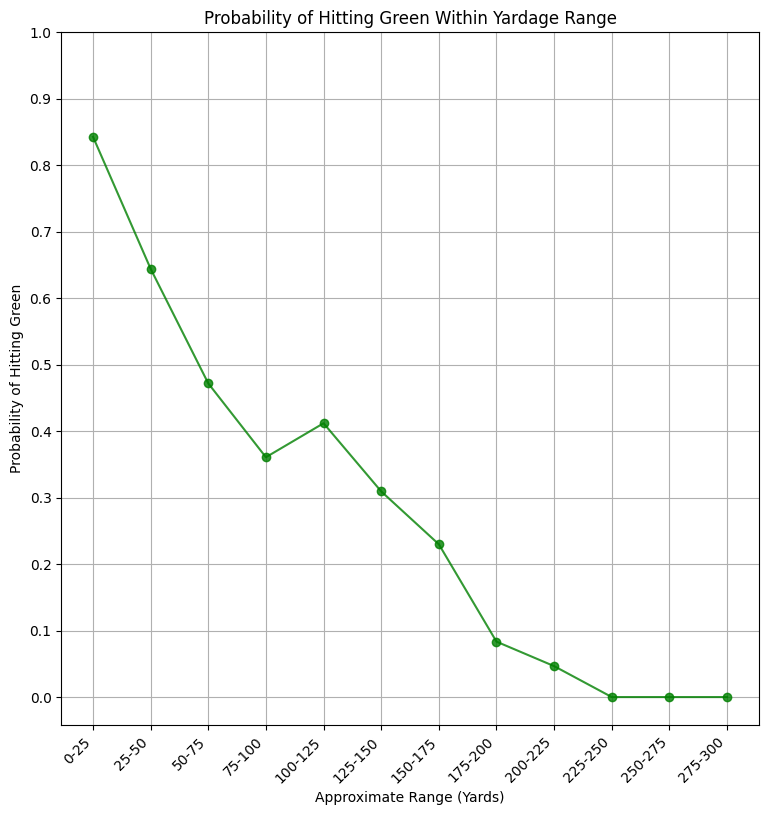

In [287]:
# Probabilities with wider ranges
probs = []
labels = []
for y in range(12):
    lower = y * 25
    upper = (y + 1) * 25
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    num_strokes_within_range_hit_green = len(strokes_with_range_hit_green)
    if num_strokes_within_range == 0:
        probs.append(0)
    else:
        probs.append(num_strokes_within_range_hit_green / num_strokes_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(probs, color='green', alpha=0.8, marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylabel('Probability of Hitting Green')
ax.set_title('Probability of Hitting Green Within Yardage Range')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range (Yards)')

Text(0.5, 0, 'Approximate Range From Green (Yards)')

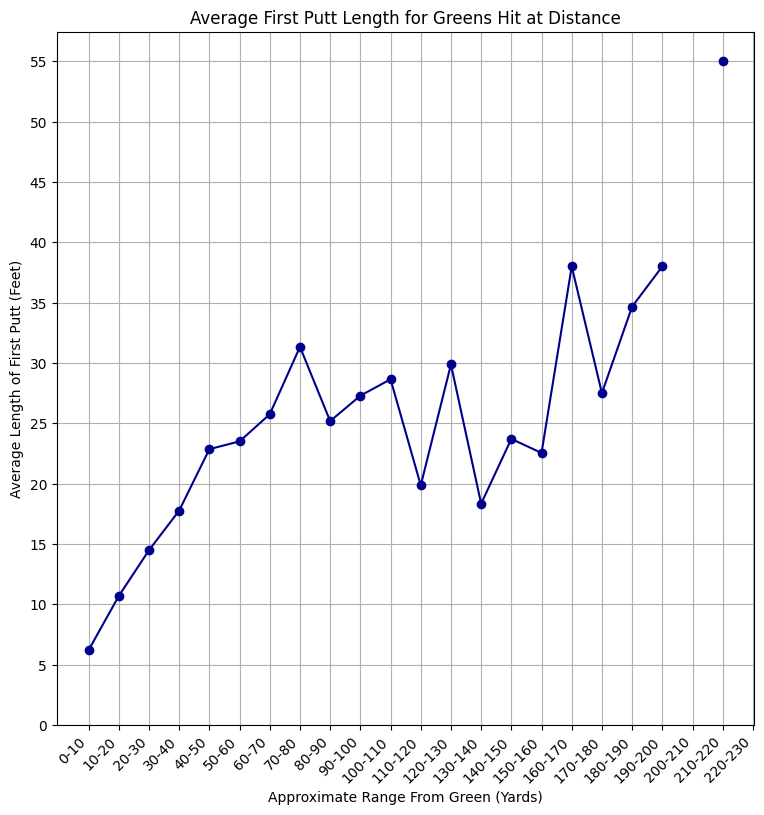

In [288]:
putt_distances = []
labels = []
for y in range(23):
    lower = y * 10
    upper = (y + 1) * 10
    all_strokes_within_range = strokes_with_green_yardages[(strokes_with_green_yardages['dist_to_green'] > lower) & (strokes_with_green_yardages['dist_to_green'] <= upper)]
    strokes_with_range_hit_green = all_strokes_within_range[all_strokes_within_range['hit_green'] == True]
    num_strokes_within_range = len(all_strokes_within_range)
    average_putt_from_hit_green_within_range = all_strokes_within_range['hit_green_putt_dist'].mean()
    putt_distances.append(average_putt_from_hit_green_within_range)
    labels.append(f"{lower}-{upper}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(putt_distances, color='darkblue', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, max(putt_distances) + 5, step=5))
ax.set_ylabel('Average Length of First Putt (Feet)')
ax.set_title('Average First Putt Length for Greens Hit at Distance')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Range From Green (Yards)')

## Section 1.1: Tee Shots

In [289]:
# Create DataFrame for tee shots
tee_strokes = strokes_df[strokes_df['stroke_number'] == 1]

In [290]:
# Group tee shots and show basic use stats
tee_strokes_by_club = tee_strokes.groupby('club')

tee_strokes_by_club_count = tee_strokes_by_club.size().reindex(ALL_CLUBS_DESC)

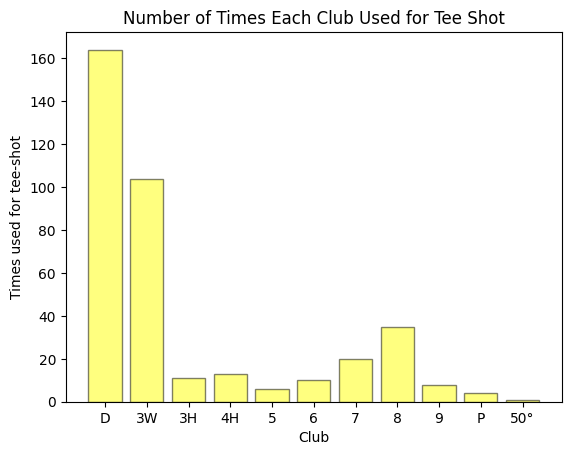

In [291]:
# Plot basic tee-shot statistics
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(tee_strokes_by_club_count.index, tee_strokes_by_club_count, color='yellow', alpha=0.5, edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Times used for tee-shot')
ax.set_title('Number of Times Each Club Used for Tee Shot')
plt.show()

In [292]:
# Load and merge stats for holes
tee_strokes = tee_strokes.merge(holestats_df, how='inner', left_on=['rnd_id', 'hole_id'], right_on=['rnd_id', 'hole_id']) \
    .merge(holes_df, how='inner', left_on='hole_id', right_on='id')

In [293]:
display(tee_strokes.head())

,id_x,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty,distance,penalty_result,...,gir,gld,scrambling,id,hole_number,nickname,par,bound_points,center_green_point,course_id
0,323,D,"[40.03085445325074, -85.95908313989639]","[40.030830257356165, -85.95999374985695]",1,37,15,0,84.839650,False,...,0,0,NaN,37,1,None,5,"[[40.030777308750565, -85.95830798149109], [40...","""[40.031098722199005, -85.96423834562302]""",5
1,327,8,"[40.03051108895679, -85.96388697624207]","[40.03091407651929, -85.96550971269608]",1,38,15,0,158.844518,False,...,0,0,NaN,38,2,None,3,"[[40.0312537805415, -85.96514225006104], [40.0...","""[40.030777308750565, -85.96547484397888]""",5
2,329,3W,"[40.0305497255487, -85.96632778644562]","[40.03129318686871, -85.96863448619843]",1,39,15,0,233.033071,False,...,0,0,NaN,39,3,None,4,"[[40.03062532997917, -85.96572160720825], [40....","""[40.03073212590795, -85.97033768892288]""",5
3,332,3W,"[40.03130550936375, -85.97076416015625]","[40.033113618842656, -85.97042620182037]",1,40,15,0,222.113455,False,...,1,1,0.0,40,4,None,4,"[[40.03073623344034, -85.97080171108246], [40....","""[40.03382502775801, -85.9706300497055]""",5
4,334,3W,"[40.0342211929881, -85.97008287906647]","[40.03397064586237, -85.9700345993042]",1,41,15,0,30.797332,True,...,0,0,NaN,41,5,None,4,"[[40.034412375741795, -85.97016870975494], [40...","""[40.03173846394828, -85.97002387046814]""",5


In [294]:
# Display GLD by club, par 4/5
tee_strokes_4_5 = tee_strokes[tee_strokes['par'] != 3]
tee_strokes_by_club = tee_strokes_4_5.groupby('club')

tee_strokes_with_gld = tee_strokes_4_5[tee_strokes_4_5['gld'] == 1]
tee_shots_with_gld_by_club = tee_strokes_with_gld.groupby('club')

gld_percentages_by_club = tee_shots_with_gld_by_club.size() / tee_strokes_by_club.size()
gld_percentages_by_club = gld_percentages_by_club.reindex(ALL_CLUBS_ASC)

Text(0, 0.5, '% Likelihood of GLD')

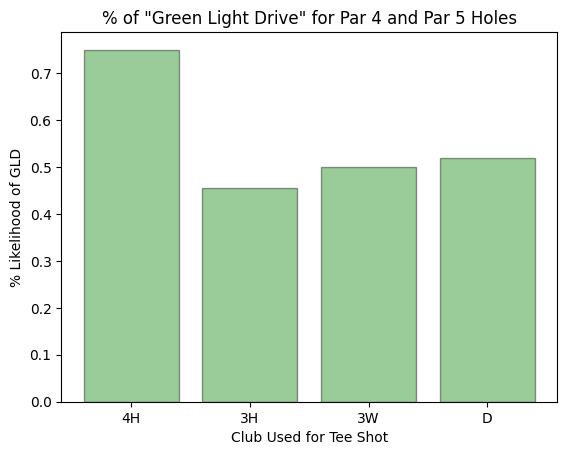

In [295]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(gld_percentages_by_club.index, gld_percentages_by_club, color='green', alpha=0.4, edgecolor='black')
ax.set_title('% of "Green Light Drive" for Par 4 and Par 5 Holes')
ax.set_xlabel('Club Used for Tee Shot')
ax.set_ylabel('% Likelihood of GLD')

In [296]:
# Display gir by club, par 3
tee_strokes_3 = tee_strokes[tee_strokes['par'] == 3]
tee_strokes_by_club = tee_strokes_3.groupby('club')

tee_strokes_with_gir = tee_strokes_3[tee_strokes_3['gir'] == 1]
tee_shots_with_gir_by_club = tee_strokes_with_gir.groupby('club')

gir_percentages_by_club = tee_shots_with_gir_by_club.size() / tee_strokes_by_club.size()
gir_percentages_by_club = gir_percentages_by_club.reindex(ALL_CLUBS_ASC)

Text(0, 0.5, '% Likelihood of GIR')

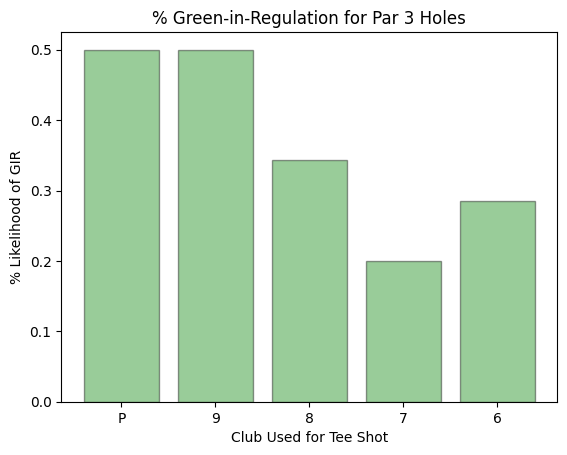

In [297]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(gir_percentages_by_club.index, gir_percentages_by_club, color='green', alpha=0.4, edgecolor='black')
ax.set_title('% Green-in-Regulation for Par 3 Holes')
ax.set_xlabel('Club Used for Tee Shot')
ax.set_ylabel('% Likelihood of GIR')

# Section 3: Penalties

In [298]:
# Display basic penalty statistics
penalty_strokes = strokes_df[strokes_df['penalty_result'] == True]

print(f'Total # of strokes taken: {len(strokes_df)}')
print(f'Total # of strokes that resulted in a penalty: {len(penalty_strokes)}')
print(f'% of strokes that result in a penalty: {(len(penalty_strokes) / len(strokes_df) * 100):.2f}%')

Total # of strokes taken: 1145
Total # of strokes that resulted in a penalty: 40
% of strokes that result in a penalty: 3.49%


In [299]:
# Penalties by club
all_strokes_by_club = strokes_df.groupby('club')
penalties_by_club = penalty_strokes.groupby('club')

penalty_percentages_by_club = penalties_by_club.size() / all_strokes_by_club.size()
penalty_percentages_by_club = penalty_percentages_by_club.reindex(ALL_CLUBS_DESC)
penalty_percentages_by_club.fillna(0, inplace=True)

Text(0.5, 1.0, 'Probability of Shot Resulting in Penalty with Each Club')

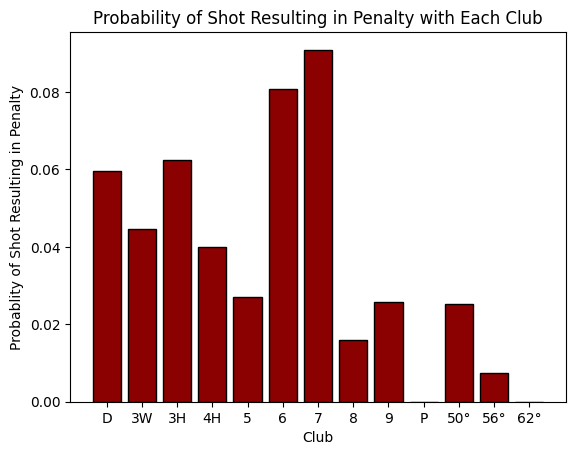

In [300]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(penalty_percentages_by_club.index, penalty_percentages_by_club, color='darkred', edgecolor='black')
ax.set_xlabel('Club')
ax.set_ylabel('Probablity of Shot Resulting in Penalty')
ax.set_title('Probability of Shot Resulting in Penalty with Each Club')

In [301]:
# Penalties by club - percentages
penalties_by_club = penalty_strokes.groupby('club').size()

penalties_by_club_count_df = pd.DataFrame(penalties_by_club, columns=['penalty_count'])
penalties_by_club_count_df['% of Penalties that Occurred with this Club'] = penalties_by_club_count_df['penalty_count'] / penalties_by_club_count_df['penalty_count'].sum() * 100
display(penalties_by_club_count_df.head())

,penalty_count,% of Penalties that Occurred with this Club
club,,
3H,2,5.0
3W,5,12.5
4H,2,5.0
5,1,2.5
50°,2,5.0


Text(0.5, 1.0, 'Percentage of Penalties Occurring with Each Club')

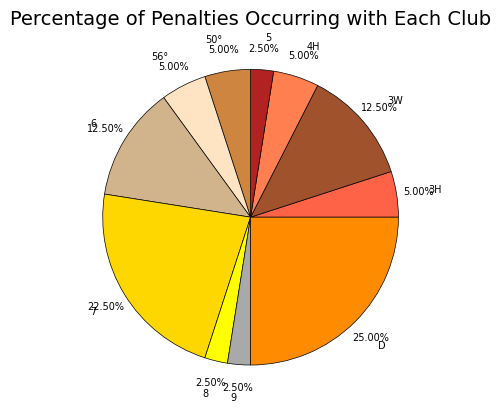

In [302]:
fig, ax = plt.subplots()
ax.pie(
    penalties_by_club_count_df['% of Penalties that Occurred with this Club'],
    labels=[c for c in penalties_by_club_count_df.index],
    autopct='%1.2f%%',
    colors=['tomato', 'sienna', 'coral', 'firebrick', 'peru', 'bisque', 'tan', 'gold', 'yellow', 'darkgrey', 'darkorange'],
    pctdistance=1.15,
    labeldistance=1.22,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
    textprops={'fontsize': 7}
)
ax.set_title('Percentage of Penalties Occurring with Each Club', fontsize=14)


In [303]:
# Penalties by stroke number
# Original Prediction: 85% of penalty shots will be from tee shot - definitely not true! Only 52.5%.
# Penalties by club
penalties_by_stroke_number = penalty_strokes.groupby('stroke_number').size()
penalties_by_stroke_number.head()

penalties_count_df = pd.DataFrame(penalties_by_stroke_number, columns=['penalty_count'])
penalties_count_df['% of Penalties that Occurred on this Stroke Number'] = penalties_count_df['penalty_count'] / penalties_count_df['penalty_count'].sum() * 100
display(penalties_count_df.head())

,penalty_count,% of Penalties that Occurred on this Stroke Number
stroke_number,,
1,21,52.5
2,10,25.0
3,7,17.5
4,1,2.5
5,1,2.5


Text(0.5, 1.0, 'Percentage of Penalties Occuring on Each Stroke')

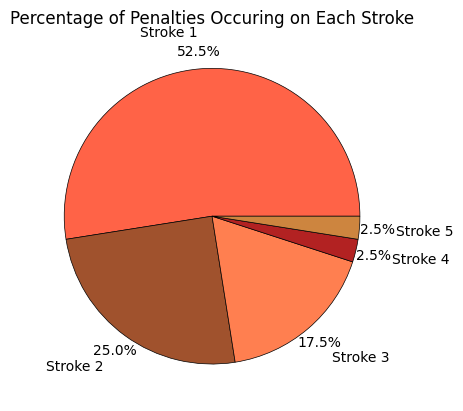

In [304]:
fig, ax = plt.subplots()
ax.pie(penalties_count_df['% of Penalties that Occurred on this Stroke Number'],
    labels=[f'Stroke {n}' for n in penalties_count_df.index],
    autopct='%1.1f%%',
    colors=['tomato', 'sienna', 'coral', 'firebrick', 'peru'],
    pctdistance=1.12,
    labeldistance=1.25,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
    )
ax.set_title('Percentage of Penalties Occuring on Each Stroke')

# Section 4: Putting

In [305]:
# Add new rows for PUTTS
def putt_was_made(row):
    return putts_df[(putts_df['rnd_id'] == row['rnd_id']) & \
        (putts_df['hole_id'] == row['hole_id']) & \
        (putts_df['stroke_number'] == row['stroke_number'] + 1) \
    ].empty

putts_df['made'] = putts_df.apply(putt_was_made, axis=1)

putts_df = putts_df[putts_df['distance'] > 0]

Text(0, 0.5, 'Number of Putts Hit')

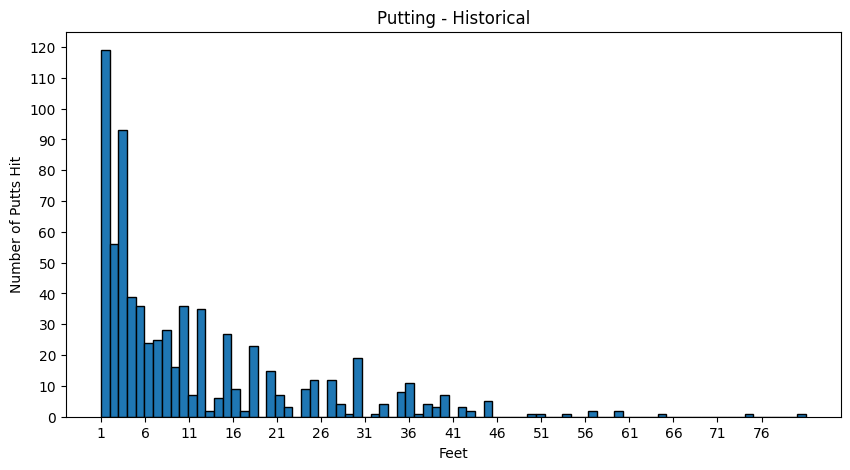

In [306]:
# Visualize Putting - Historically
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
ax = fig.add_subplot(1, 1, 1)
ax.hist(putts_df['distance'], bins=putts_df['distance'].max(), edgecolor='black')
ax.set_title('Putting - Historical')
ax.set_xticks(range(1, putts_df['distance'].max(), 5))
ax.set_xlabel('Feet')
ax.set_yticks(range(0, 130, 10))
ax.set_ylabel('Number of Putts Hit')

Text(0, 0.5, 'Probability of Making Putt')

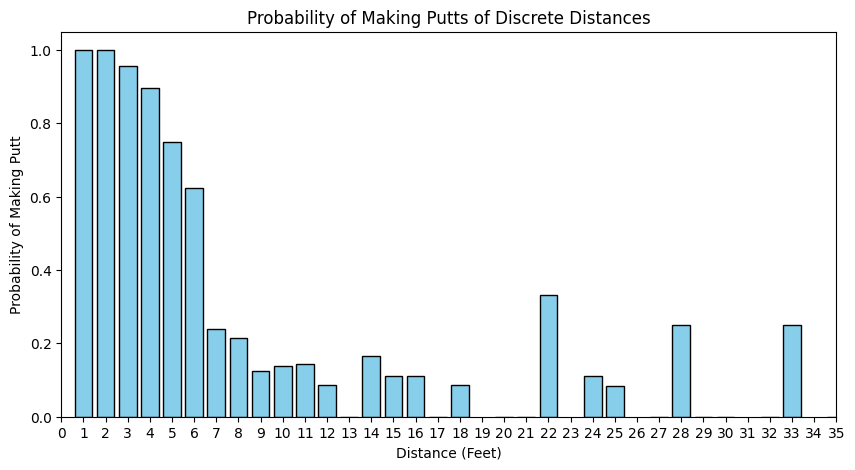

In [307]:
# Percent Likelihood of Making Putts
all_putts_by_distance = putts_df.groupby('distance')
made_putts_by_distance = putts_df[putts_df['made'] == True].groupby('distance')

make_likelihood_by_distance = made_putts_by_distance.size() / all_putts_by_distance.size()

make_likelihood_by_distance = make_likelihood_by_distance.fillna(0)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
ax = fig.add_subplot(1, 1, 1)
ax.bar(make_likelihood_by_distance.index, make_likelihood_by_distance, color='skyblue', edgecolor='black')
ax.set_xticks(range(0, max(putts_df['distance']), 5))
ax.set_xlim(0, 35)
ax.set_xticks(range(36))  # Position ticks at the indices
ax.set_xticklabels(range(36), ha='center')
ax.set_title('Probability of Making Putts of Discrete Distances')
ax.set_xlabel('Distance (Feet)')
ax.set_ylabel('Probability of Making Putt')

Text(0.5, 0, 'Approximate Distance (Feet)')

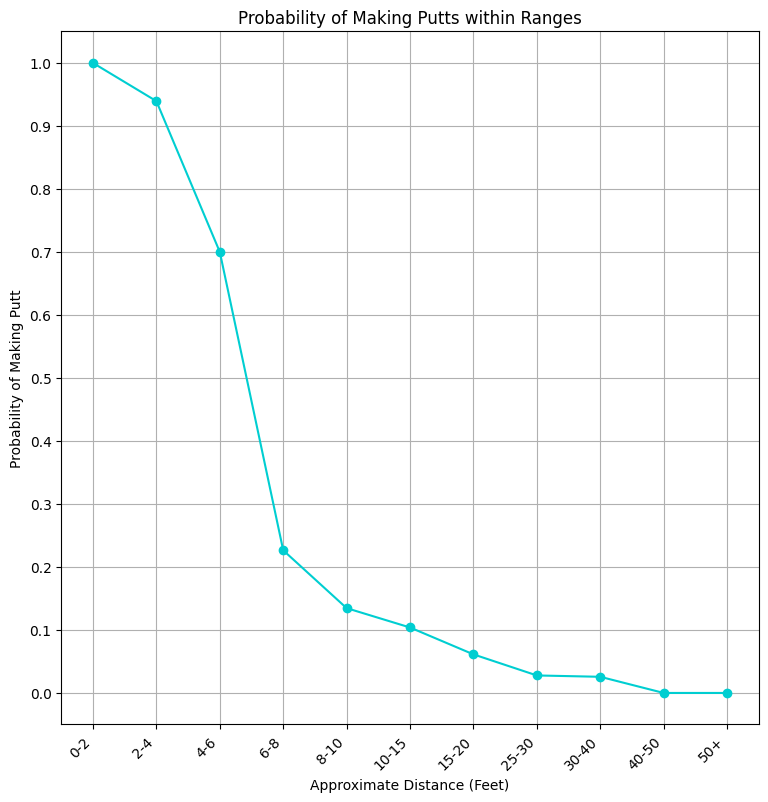

In [308]:
# Clarify putting make-probability using regions
regions = [
    (0, 2),
    (2, 4),
    (4, 6),
    (6, 8),
    (8, 10),
    (10, 15),
    (15, 20),
    (25, 30),
    (30, 40),
    (40, 50),
    (50, 100)
]

probs = []
labels = []
for i, region in enumerate(regions):
    all_putts_within_region = putts_df[(putts_df['distance'] > region[0]) & (putts_df['distance'] <= region[1])]
    putts_within_region_made = all_putts_within_region[all_putts_within_region['made'] == True]
    num_putts_within_region = len(all_putts_within_region)
    num_putts_within_region_made = len(putts_within_region_made)
    if num_putts_within_region == 0:
        probs.append(0)
    else:
        probs.append(num_putts_within_region_made / num_putts_within_region)

    if i == len(regions) - 1:
        labels.append(f'{region[0]}+')
    else:
        labels.append(f"{region[0]}-{region[1]}")  # Create labels for x-ticks
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(probs, color='darkturquoise', marker='o')
ax.grid(True)
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_ylabel('Probability of Making Putt')
ax.set_title('Probability of Making Putts within Ranges')
ax.set_xticks(range(len(labels)))  # Position ticks at the indices
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Approximate Distance (Feet)')

In [309]:
# Breakdown by hole - 1/2/3/... putts
putts_by_hole = putts_df.groupby(['rnd_id', 'hole_id']).size()
value_counts = putts_by_hole.value_counts().sort_index()

putts_count_df = pd.DataFrame(value_counts)
putts_count_df.columns = ['Instances']  # Rename the column for clarity
putts_count_df.index.name = 'Number of Putts for Hole'  # Set the index name
putts_count_df['% of Holes Played with Amount of Putts'] = putts_count_df['Instances'] / len(putts_count_df)
display(putts_count_df)

,Instances,% of Holes Played with Amount of Putts
Number of Putts for Hole,,
1,85,21.25
2,236,59.00
3,53,13.25
4,2,0.50


Text(0.5, 1.0, 'Percentage of Number of Putts for All Holes Played')

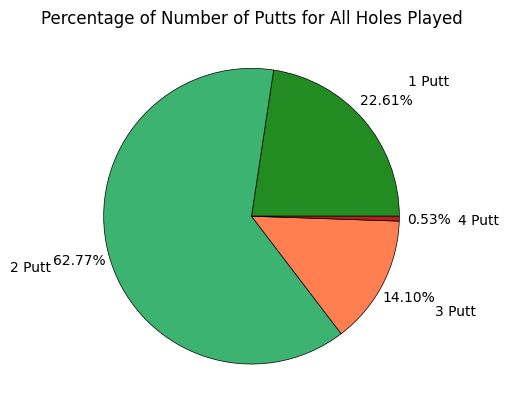

In [310]:
fig, ax = plt.subplots()
ax.pie(putts_count_df['% of Holes Played with Amount of Putts'],
    labels=[f'{n} Putt' for n in putts_count_df.index],
    autopct='%1.2f%%',
    colors=['forestgreen', 'mediumseagreen', 'coral', 'firebrick'],
    pctdistance=1.2,
    labeldistance=1.4,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},

    )
ax.set_title('Percentage of Number of Putts for All Holes Played')